In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from skimage.io import imread

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
train = pd.read_csv('/kaggle/input/handwritten-medicine-data/train.csv')
valid = pd.read_csv('/kaggle/input/handwritten-medicine-data/validate.csv')

## Load and view data

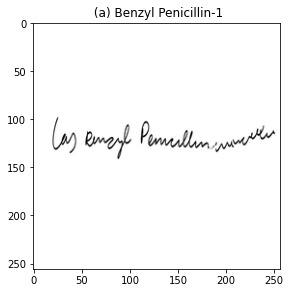

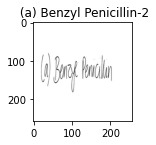

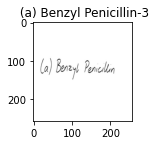

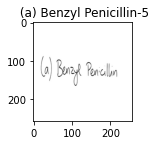

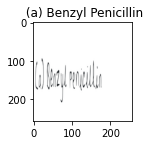

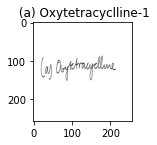

<Figure size 432x288 with 0 Axes>

In [3]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwritten-medicine-data/images/images/train/'+train.loc[i, 'FILENAME']
    image = mpimg.imread(img_dir)
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)

    imgplot = plt.imshow(image)
    plt.show()
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [4]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [5]:
# train.dropna(axis=0, inplace=True)
# valid.dropna(axis=0, inplace=True)

In [6]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

In [7]:
# unreadable = train[train['IDENTITY'] == 'UNREADABLE']
# unreadable.reset_index(inplace = True, drop=True)

# plt.figure(figsize=(15, 10))

# for i in range(6):
#     ax = plt.subplot(2, 3, i+1)
#     img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap = 'gray')
#     plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
#     plt.axis('off')

# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
# train = train[train['IDENTITY'] != 'UNREADABLE']
# valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [9]:
# train['IDENTITY'] = train['IDENTITY'].str.upper()
# valid['IDENTITY'] = valid['IDENTITY'].str.upper()

Reset the index and we are done with cleaning. 

In [10]:
# train.reset_index(inplace = True, drop=True) 
# valid.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y). 
* The image is then normalized to range [0, 1]

In [11]:
def preprocess(img):
#     return(img)
#     (h, w) = img.shape
    
#     final_img = np.ones([181, 1056])*255 # blank white image

#     if w > 1056:
#         img = img[:, :1056]
    
    
#     if h > 181:
#         img = img[:181, :]
    
    
#     final_img[:h, :w] = img
    
#     final_img = cv2.resize(final_img,(256,64)) 
    return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [12]:
train_size = 1718
valid_size= 306

/kaggle/input/handwritten-medicine-data/images/images/train/Bitablockers-1.png
(256, 256)


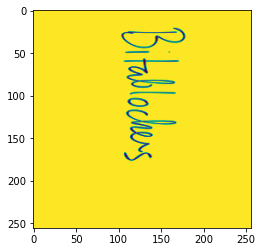

In [13]:
img_dir = '/kaggle/input/handwritten-medicine-data/images/images/train/'+train.loc[300, 'FILENAME']

print(img_dir)
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
print(image.shape)
image = preprocess(image)
imgplot = plt.imshow(image)
plt.show()

In [14]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwritten-medicine-data/images/images/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    imgae = np.array(image)
    image = image/255.
    train_x.append(image)

In [15]:
# train_x[0].shape

In [16]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwritten-medicine-data/images/images/validate/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [17]:
train_x = np.array(train_x).reshape(-1,256,256,1)
valid_x = np.array(valid_x).reshape(-1,256,256,1)
# train_x
# valid_x

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [18]:
# alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-:–&().’' "
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-12345670’–)(_. "
max_str_len = 50 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [19]:
name = 'Dulaglutide'
newname = label_to_num(name)
print(name, '\n', newname)
name2 = num_to_label(newname)
print(name, '\n', name2)

Dulaglutide 
 [ 3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Dulaglutide 
 D


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss. 


In [20]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [21]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [22]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :   ACTIVE INGREDIENTS OF MARIJUANA-4 
train_y :  [41.  0.  2. 19.  8. 21.  4. 41.  8. 13.  6. 17.  4.  3.  8.  4. 13. 19.
 18. 41. 14.  5. 41. 12.  0. 17.  8.  9. 20.  0. 13.  0. 26. 30. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [34.] 
train_input_len :  [62.]


In [23]:
# alphabets[54]

In [24]:
train_x[100]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

## Building our model


In [25]:
input_data = Input(shape=(256, 256, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 4096)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)     

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [26]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [27]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [28]:
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)
# print("Shape of train_x:", train_label_len.shape)
# print("Shape of train_y:", train_input_len.shape)
# print("Shape of train_x:", train_output.shape)


Shape of train_x: (1718, 256, 256, 1)
Shape of train_y: (1718, 50)


## Train our model

In [29]:

# mohit = [77,12,30,43,28,46,43,50,77,26,39,29,77,8,45,-1,44,77,28,40,38,41,40,46,39,29,52,57]

# for i in mohit:
#     print(alphabets[i])

In [30]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=120, batch_size=40)

Epoch 1/120
43/43 [==============================] - 7s 156ms/step - loss: 72.7857 - val_loss: 57.2979
Epoch 2/120
43/43 [==============================] - 5s 105ms/step - loss: 53.4761 - val_loss: 55.9780
Epoch 3/120
43/43 [==============================] - 5s 105ms/step - loss: 49.9222 - val_loss: 53.0874
Epoch 4/120
43/43 [==============================] - 4s 105ms/step - loss: 47.2336 - val_loss: 51.9580
Epoch 5/120
43/43 [==============================] - 5s 105ms/step - loss: 45.1339 - val_loss: 49.5765
Epoch 6/120
43/43 [==============================] - 5s 106ms/step - loss: 43.7799 - val_loss: 47.8815
Epoch 7/120
43/43 [==============================] - 5s 105ms/step - loss: 42.9342 - val_loss: 47.6442
Epoch 8/120
43/43 [==============================] - 5s 107ms/step - loss: 42.2826 - val_loss: 46.8348
Epoch 9/120
43/43 [==============================] - 5s 105ms/step - loss: 41.8382 - val_loss: 46.4097
Epoch 10/120
43/43 [==============================] - 5s 105ms/step - los

## Check model performance on validation set

In [31]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [32]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == '-':
            break
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 42.90%
Correct words predicted      : 5.23%


## Some predictions on test set

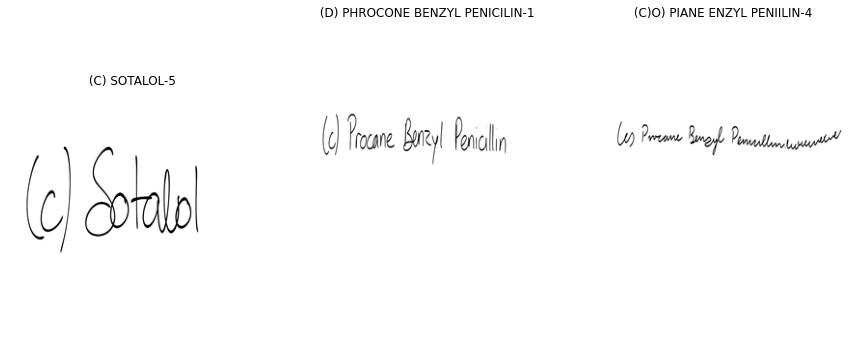

In [33]:
test = pd.read_csv('/kaggle/input/handwritten-medicine-data/test.csv')

plt.figure(figsize=(15, 10))
for i in range(7,10):
    empty = []
    ax = plt.subplot(4, 3, i+1)
    img_dir = '/kaggle/input/handwritten-medicine-data/images/images/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 256,1))
    
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
#     for i in decoded:
#         for j in i:
#             if j!= -1:
#                 print(j)
#                 empty.append(alphabets[j])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [34]:
model.save("hand1.h5")